In [1]:
#import all required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# read the data and change column names
# skip first observation as it has the default column names

df = pd.read_csv('perrin-freres-monthly-champagne-.csv', names=['Month', 'Sales'], parse_dates=True, skiprows=1)
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [3]:
# total 107 observations
# 2 observation has null value for sales column
# 1 observation has null value for Month column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   106 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [4]:
# check if null observation is common for both columns
# One observation is common

df[df.isna().any(axis=1)]

,Month,Sales
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [5]:
# drop observations with null values

df.dropna(inplace=True)
df[df.isna().any(axis=1)]

,Month,Sales


In [6]:
# change the Month column into DataTime column
# Make Month as an index

df.Month = pd.to_datetime(df.Month)
df.set_index('Month', inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


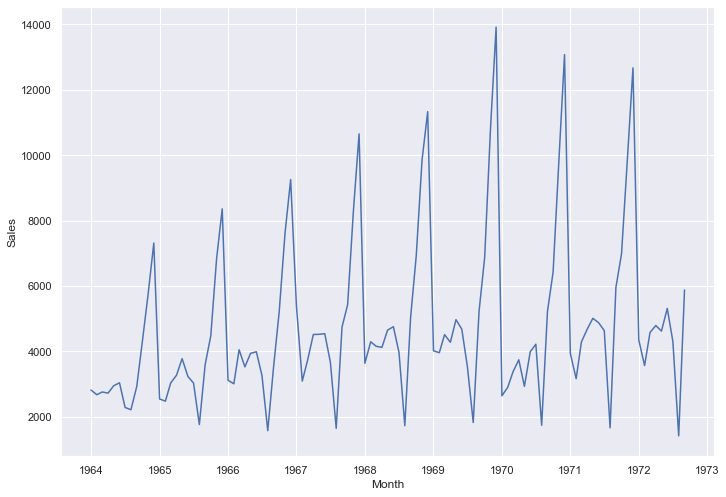

In [7]:
# plot the series data
# The line is oscillating, there is some seasonality in the data

sns.lineplot(data= df, x=df.index, y='Sales');

In [8]:
# use adFuller method to check stationarity in the data
# null H = The data has a unit root and does not have stationarity
# alternate H = The data does not have a unit root hence the data has stationarity
# pvalue < 0.05 reject the null hypothesis, means data has stationarity
# pvalue > 0.05 failed to rejec null hypothesis.  

from statsmodels.tsa.stattools import adfuller

def exec_adfuller(univar_data):
    labels = ['adf_stats','pvalue','usedlag','nobs','critical values','icbest']
    res = adfuller(univar_data)
    res = dict(zip(labels, res))
    if res['pvalue'] < 0.05:
        return 'data does not have a unit root and has stationarity'
    else:
        return 'data has a unit root and has no stationarity'

exec_adfuller(df.Sales)

'data has a unit root and has no stationarity'

In [9]:
df['salesDiff_1'] = df['Sales'] - df['Sales'].shift(1)
df.head()

,Sales,salesDiff_1
Month,,
1964-01-01,2815.0,NaN
1964-02-01,2672.0,-143.0
1964-03-01,2755.0,83.0
1964-04-01,2721.0,-34.0
1964-05-01,2946.0,225.0


In [10]:
df['seasonalSalesDiff_1'] = df['Sales'] - df['Sales'].shift(12)
df.head()

,Sales,salesDiff_1,seasonalSalesDiff_1
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN


In [11]:
# Check for pValue from ADF
# with 12 shifts the data has stationarity

exec_adfuller(df.seasonalSalesDiff_1.dropna())

'data does not have a unit root and has stationarity'

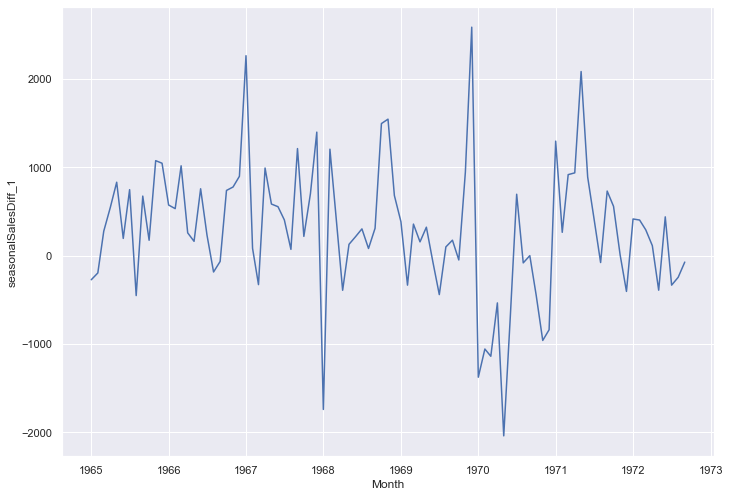

In [12]:
# plot the seasonal data
# The line is oscillating, there is some seasonality in the data

sns.lineplot(data= df, x=df.index, y='seasonalSalesDiff_1');

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

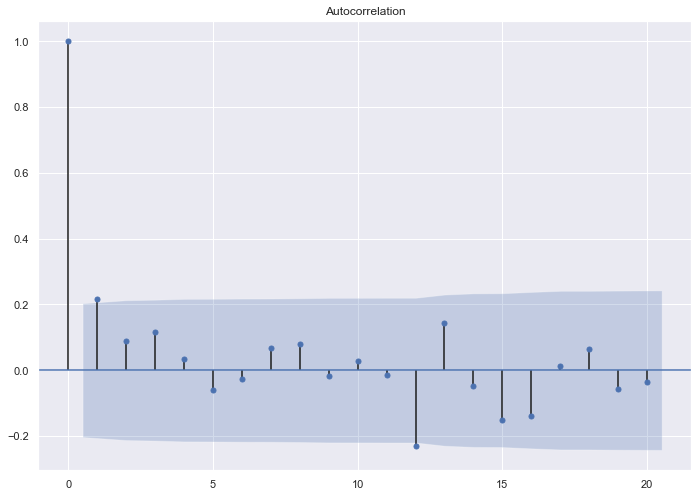

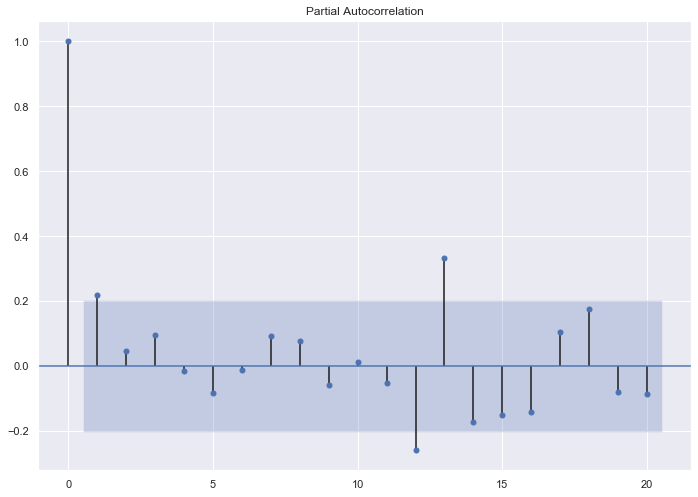

In [14]:
# for pacf there is sudden drop after 1 log. It indicates we can assume p=1
# for acf there is drop after 1 lag, It indicates we can assume q=1

plot_acf(df.seasonalSalesDiff_1.dropna());
plot_pacf(df.seasonalSalesDiff_1.dropna());

In [15]:
from statsmodels.tsa.arima_model import ARIMA

In [16]:
model = ARIMA(df.Sales, order=(1,1,1))
model = model.fit()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Thu, 26 Aug 2021   AIC                           1910.251
Time:                        16:25:45   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7842     12.405      1.837      0.066      -1.530      47.098
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

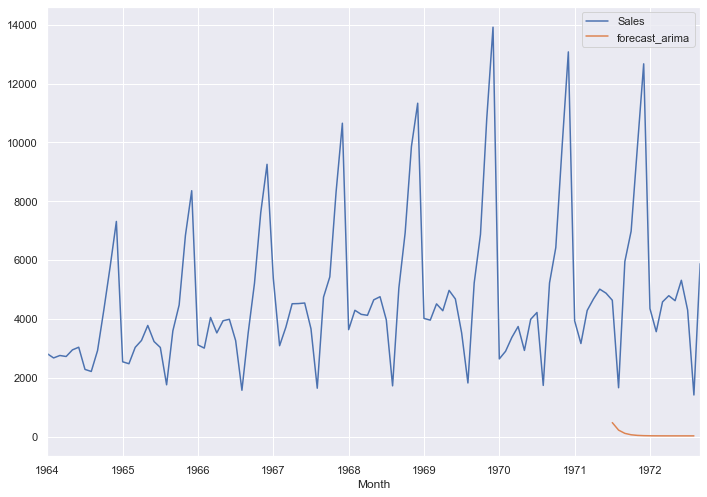

In [18]:
df['forecast_arima'] = model.predict(start=90, end=103, dynamic=True)
df[['Sales', 'forecast_arima']].plot()

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [20]:
model_1 = SARIMAX(df['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_1 = model_1.fit()

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [21]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Thu, 26 Aug 2021   AIC                           1486.804
Time:                                    16:25:49   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (Q):                       40.24   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.46   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

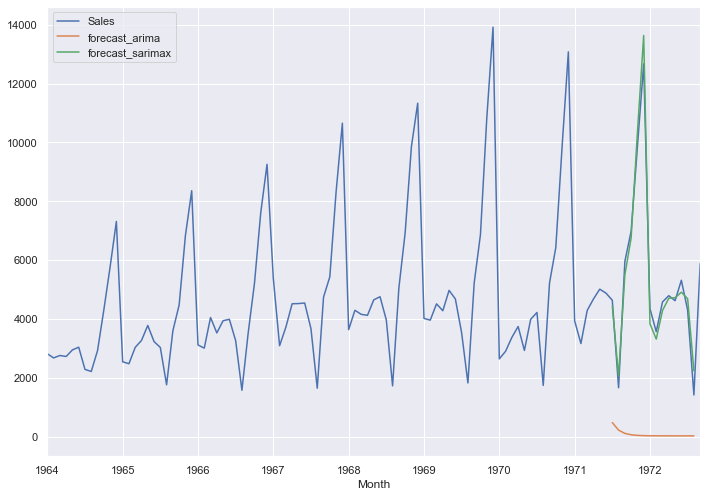

In [22]:
df['forecast_sarimax'] = model_1.predict(start=90, end=103, dynamic=True)
df[['Sales', 'forecast_arima', 'forecast_sarimax']].plot()

In [23]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1]+DateOffset(months=x) for x in range(0,24)]
future_dates

[Timestamp('1972-09-01 00:00:00'),
 Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00')]

In [24]:
future_df = pd.DataFrame(index=future_dates[1:], columns=df.columns)
future_df.index

DatetimeIndex(['1972-10-01', '1972-11-01', '1972-12-01', '1973-01-01',
               '1973-02-01', '1973-03-01', '1973-04-01', '1973-05-01',
               '1973-06-01', '1973-07-01', '1973-08-01', '1973-09-01',
               '1973-10-01', '1973-11-01', '1973-12-01', '1974-01-01',
               '1974-02-01', '1974-03-01', '1974-04-01', '1974-05-01',
               '1974-06-01', '1974-07-01', '1974-08-01'],
              dtype='datetime64[ns]', freq=None)

In [25]:
future_df = pd.concat([df, future_df])
df.tail()

,Sales,salesDiff_1,seasonalSalesDiff_1,forecast_arima,forecast_sarimax
Month,,,,,
1972-05-01,4618.0,-170.0,-392.0,22.891835,4717.511639
1972-06-01,5312.0,694.0,438.0,22.830967,4906.404408
1972-07-01,4298.0,-1014.0,-335.0,22.804529,4685.437172
1972-08-01,1413.0,-2885.0,-246.0,22.793046,2232.408859
1972-09-01,5877.0,4464.0,-74.0,NaN,NaN


In [26]:
future_df['forecast_sarimax_fut'] = model_1.predict(start=104, end=120, dynamic=True)
future_df.tail()

,Sales,salesDiff_1,seasonalSalesDiff_1,forecast_arima,forecast_sarimax,forecast_sarimax_fut
1974-04-01,NaN,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN,NaN,NaN


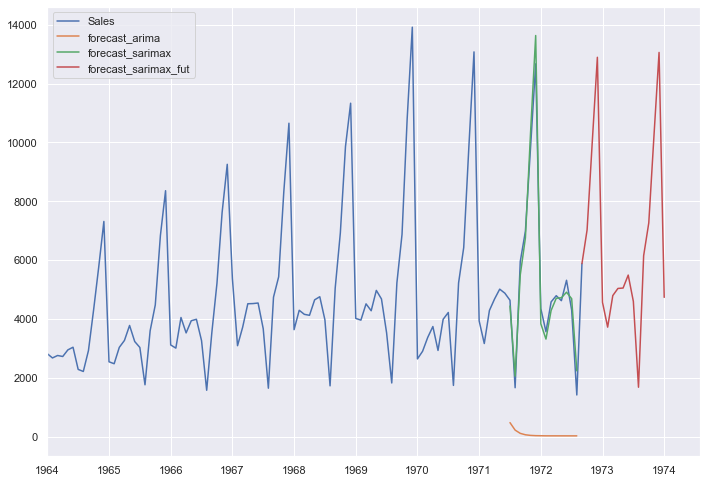

In [27]:
future_df[['Sales', 'forecast_arima', 'forecast_sarimax', 'forecast_sarimax_fut']].plot()

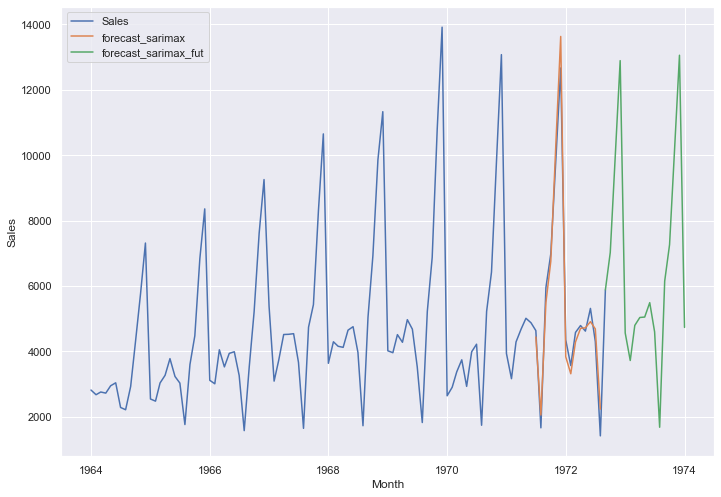

In [28]:
sns.lineplot(data=df, x=df.index, y='Sales', label='Sales');
sns.lineplot(data= df, x=df.index, y='forecast_sarimax', label='forecast_sarimax');
sns.lineplot(data= future_df, x=future_df.index, y='forecast_sarimax_fut', label='forecast_sarimax_fut');
plt.legend();

In [29]:
future_df[-24:]

,Sales,salesDiff_1,seasonalSalesDiff_1,forecast_arima,forecast_sarimax,forecast_sarimax_fut
1972-09-01,5877.0,4464.0,-74.0,NaN,NaN,5878.712046
1972-10-01,NaN,NaN,NaN,NaN,NaN,7024.263246
1972-11-01,NaN,NaN,NaN,NaN,NaN,9996.419751
1972-12-01,NaN,NaN,NaN,NaN,NaN,12892.152546
1973-01-01,NaN,NaN,NaN,NaN,NaN,4561.509764
1973-02-01,NaN,NaN,NaN,NaN,NaN,3718.817804
1973-03-01,NaN,NaN,NaN,NaN,NaN,4792.361213
1973-04-01,NaN,NaN,NaN,NaN,NaN,5034.610610
1973-05-01,NaN,NaN,NaN,NaN,NaN,5047.956800
1973-06-01,NaN,NaN,NaN,NaN,NaN,5488.573485
